In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily CAD/JPY Exchange Rate Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

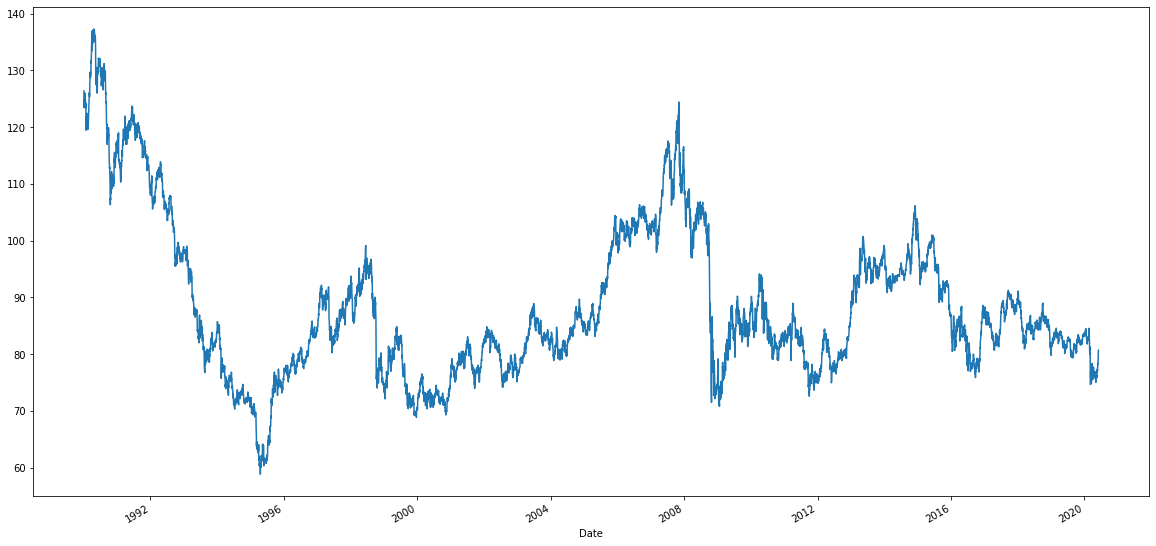

In [6]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot(figsize=(20, 10))

 *Answer*
 * Based on the plot above, we can see a long-term weakening of the Japanese Yen respective to the Canadian Dollar. There do seem to be some more medium, 1-3 year consistent trends, but on a daily basis, there are a lot of short-term ups and downs.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into a trend and noise.

In [51]:
import statsmodels.api as sm
# Apply the Hodrick-Prescott Filter by decomposing the "Price" into two separate series:

cad_jpy_noise, cad_jpy_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

In [52]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
exchange_rate_df = cad_jpy_df
exchange_rate_df = exchange_rate_df.drop(columns =['Open','High','Low'])
exchange_rate_df['noise'] = cad_jpy_noise
exchange_rate_df['trend'] = cad_jpy_trend
exchange_rate_df.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


TypeError: unsupported operand type(s) for *: 'AxesSubplot' and 'AxesSubplot'

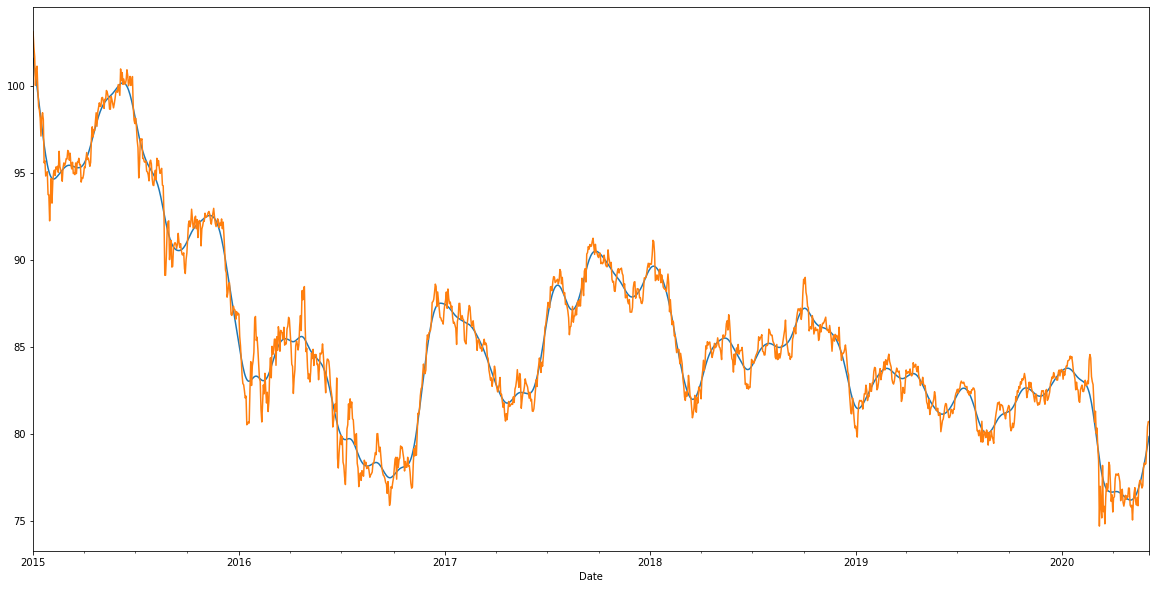

In [65]:
# Plot the exchange rate Price vs. the Trend for 2015 to the present
cad_jpy_trend.loc['2015-01-01':].plot(figsize=(20, 10)) * cad_jpy_df.Price.loc['2015-01-01':].plot(figsize=(20, 10))

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

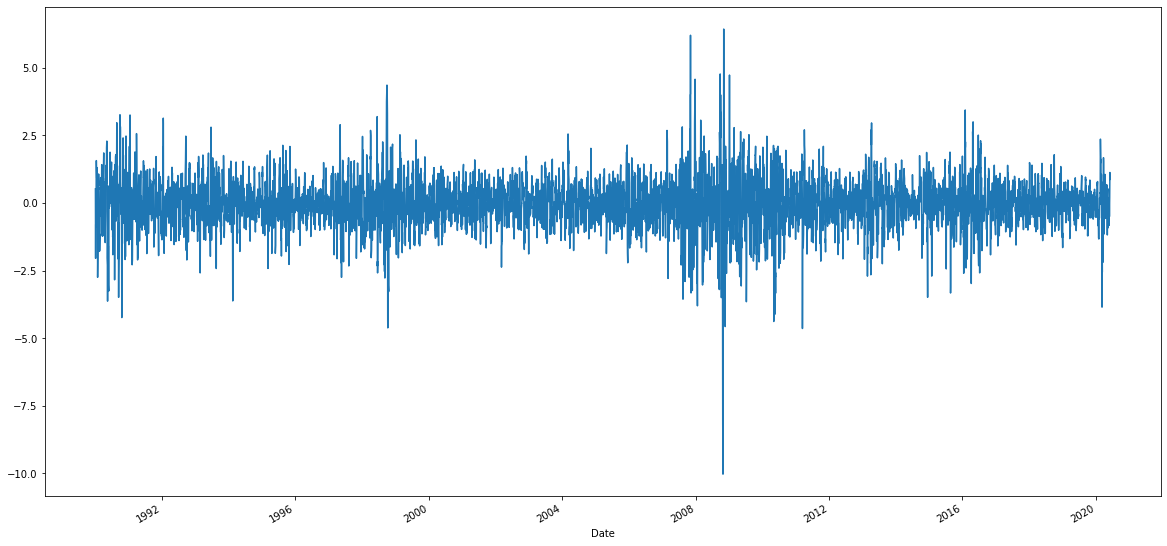

In [66]:
# Plot the Price Noise
cad_jpy_noise.plot(figsize=(20, 10))

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [67]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [69]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [70]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Sun, 16 Aug 2020   AIC                          19513.955
Time:                        16:23:01   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1700           +0.0000j           42.1700            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

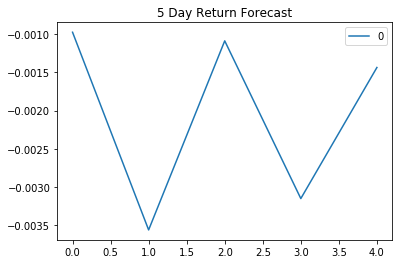

In [71]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Return Forecast")

Question: Based on the p-value, is the model a good fit?

Answer: 

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Exchange Rate Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [72]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(cad_jpy_df['Price'], order=(5, 1, 2))

# Fit the model
results = model.fit()

C:\Users\Dell XPS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Dell XPS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [73]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -8742.281
Method:                       css-mle   S.D. of innovations              0.729
Date:                Sun, 16 Aug 2020   AIC                          17502.563
Time:                        16:34:16   BIC                          17565.366
Sample:                             1   HQIC                         17524.069
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.727      0.467      -0.021       0.010
ar.L1.D.Price     0.3657      0.029     12.484      0.000       0.308       0.423
ar.L2.D.Price    -0.9361      0.037    -25.640      0.000      -1.008      -0.865
ar.L3.D.Price    -0.0383      0.016     -2.398      0.016      -0.070      -0.007
ar.L4.D.Price     0.0162      0.012      1.314      0.189      -0.008       0.040
ar.L5.D.Price    -0.0180      0.012     -1.527      0.127      -0.041       0.005
ma.L1.D.Price    -0.3939      0.027    -14.532      0.000      -0.447      -0.341
ma.L2.D.Price     0.9534      0.035     27.497      0.000       0.885       1.021
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.2008           -1.0051j            1.0250           -0.2186
AR.2            0.2008           +1.0051j            1.0250            0.2186
AR.3           -3.5222           -0.0000j            3.5222           -0.5000
AR.4            2.0096           -3.3160j            3.8774           -0.1633
AR.5            2.0096           +3.3160j            3.8774            0.1633
MA.1            0.2066           -1.0031j            1.0242           -0.2177
MA.2            0.2066           +1.0031j            1.0242            0.2177
-----------------------------------------------------------------------------
"""

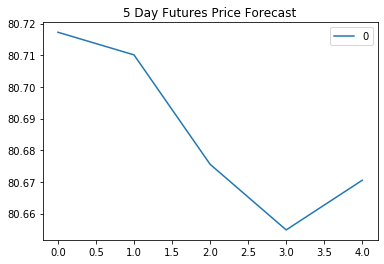

In [74]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

What does the model forecast will happen to the Japanese Yen in the near term?

Answer:

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [78]:
from arch import arch_model

In [79]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
res = model.fit(disp="off")

In [80]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Sun, Aug 16 2020   Df Residuals:                     7924
Time:                        16:42:13   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]   2.7064e-07  2.010e-02  1.346e-05      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

Note, our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. 

In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [81]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [82]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = res.forecast(start='2020-06-04', horizon=forecast_horizon)
forecasts

In [83]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566012,12.573698,12.58128,12.588757,12.596131


In [84]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566012
h.2,12.573698
h.3,12.581280
h.4,12.588757
h.5,12.596131


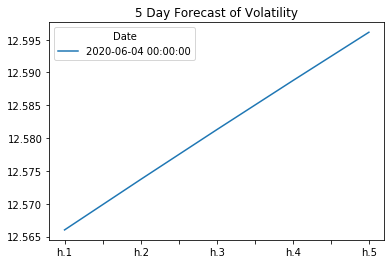

In [86]:
# Plot the final forecast
final.plot(title="5 Day Forecast of Volatility")

Based on the graph above, the forecast for CAD/JPY volatility is that it is expected to rise over the next 5 days. 

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?